In [1]:
import keras
from keras.datasets import cifar10
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
# import os

Using TensorFlow backend.


In [2]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## 首先我們使用一般的 DNN (MLP) 來訓練
由於 DNN 只能輸入一維的資料，我們要先將影像進行攤平，若 (50000, 32, 32, 3) 的影像，攤平後會變成 (50000, 32*32*3) = (50000, 3072)

In [3]:
# 將資料攤平成一維資料
x_train = x_train.reshape(50000, 3072) 
x_test = x_test.reshape(10000, 3072)

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [4]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(3072,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 1,841,162
Trainable params: 1,841,162
Non-trainable params: 0
___________

## 接下來我們使用 CNN 來訓練神經網路
CNN 的原理非常適合處理影像類的資料，就讓我們來看看，同樣的訓練條件，CNN 是否顯著優於 DNN 呢?

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
x_train.shape[1:]

(32, 32, 3)

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [8]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(history.history[train_acc])
    plt.plot(history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

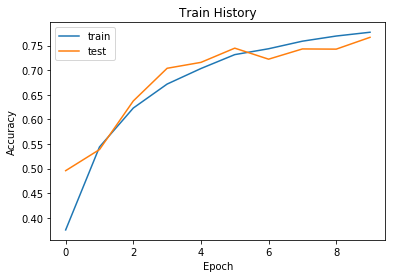

In [9]:
show_train_history('acc','val_acc')

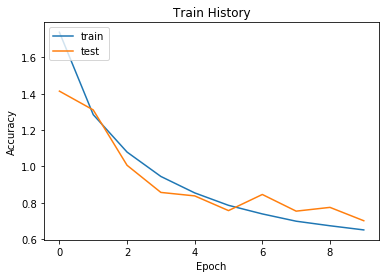

In [10]:
show_train_history('loss','val_loss')

## 同樣運算 10 個 epochs，但 CNN 在 test data 的準確率顯著優於 DNN!

## 作業
1. 請試著調整各個超參數，並說明那些超參數對於結果有明顯的影響?
2. CNN 與 DNN 哪個模型的參數數量比較多? 造成參數的數量不同的原因在哪?

1. 可以調整的有: Conv2D 的層數、filters 數量、stride 大小、學習率的大小、優化器的選擇、Dropout 的比率等等。其中 Conv2D 的層數與優化器的選擇對結果會有較明顯的影響。
2. DNN 的參數量較多，可以看出 CNN 在做卷機時，透過較小的參數量就可以逐步縮小影像大小，讓最後再接上 Dense 層時不要有過多的參數。

# Day71-LossFunction 比較

In [13]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

# serialize weights to HDF5
model.save_weights("Day097model.h5")
print("Saved model to disk")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_20 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [14]:
'''
作業:'categorical_crossentropy'
請分別選用 "MSE", "binary _crossentropy"
查看Train/test accurancy and loss rate
'''

'\n作業:\'categorical_crossentropy\'\n請分別選用 "MSE", "binary _crossentropy"\n查看Train/test accurancy and loss rate\n'

In [15]:
try:
    model.load_weights("Day097model.h5")
    print("載入模型成功!繼續訓練模型")
except :    
    print("載入模型失敗!開始訓練一個新模型")

載入模型成功!繼續訓練模型


In [16]:
model.compile(loss='MSE',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 163s 3ms/step - loss: 0.0767 - acc: 0.3496 - val_loss: 0.0643 - val_acc: 0.4950
Epoch 2/10
50000/50000 [==============================] - 186s 4ms/step - loss: 0.0619 - acc: 0.5152 - val_loss: 0.0534 - val_acc: 0.5956
Epoch 3/10
50000/50000 [==============================] - 190s 4ms/step - loss: 0.0532 - acc: 0.5958 - val_loss: 0.0496 - val_acc: 0.6252
Epoch 4/10
50000/50000 [==============================] - 189s 4ms/step - loss: 0.0472 - acc: 0.6501 - val_loss: 0.0517 - val_acc: 0.6199
Epoch 5/10
50000/50000 [==============================] - 193s 4ms/step - loss: 0.0433 - acc: 0.6826 - val_loss: 0.0382 - val_acc: 0.7149
Epoch 6/10
50000/50000 [==============================] - 191s 4ms/step - loss: 0.0400 - acc: 0.7089 - val_loss: 0.0376 - val_acc: 0.7214
Epoch 7/10
50000/50000 [==============================] - 195s 4ms/step - loss: 0.0377 - acc: 0.7267 - val_loss: 0.0349 - 

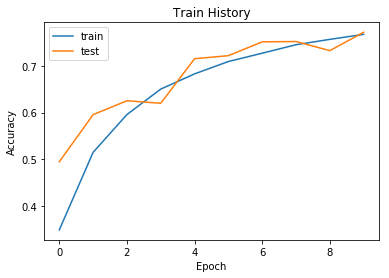

In [17]:
show_train_history('acc','val_acc')

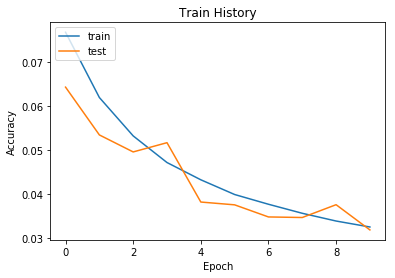

In [18]:
show_train_history('loss','val_loss')

In [19]:
try:
    model.load_weights("Day097model.h5")
    print("載入模型成功!繼續訓練模型")
except :    
    print("載入模型失敗!開始訓練一個新模型")

載入模型成功!繼續訓練模型


In [21]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 172s 3ms/step - loss: 0.2639 - acc: 0.9049 - val_loss: 0.2312 - val_acc: 0.9113
Epoch 2/10
50000/50000 [==============================] - 186s 4ms/step - loss: 0.2048 - acc: 0.9206 - val_loss: 0.1809 - val_acc: 0.9283
Epoch 3/10
50000/50000 [==============================] - 187s 4ms/step - loss: 0.1739 - acc: 0.9323 - val_loss: 0.1677 - val_acc: 0.9330
Epoch 4/10
50000/50000 [==============================] - 188s 4ms/step - loss: 0.1539 - acc: 0.9401 - val_loss: 0.1487 - val_acc: 0.9426
Epoch 5/10
50000/50000 [==============================] - 193s 4ms/step - loss: 0.1413 - acc: 0.9450 - val_loss: 0.1301 - val_acc: 0.9492
Epoch 6/10
50000/50000 [==============================] - 187s 4ms/step - loss: 0.1317 - acc: 0.9487 - val_loss: 0.1264 - val_acc: 0.9501
Epoch 7/10
50000/50000 [==============================] - 197s 4ms/step - loss: 0.1241 - acc: 0.9518 - val_loss: 0.1356 - 

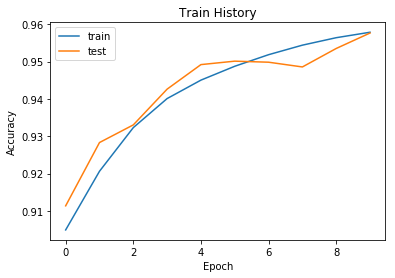

In [22]:
show_train_history('acc','val_acc')

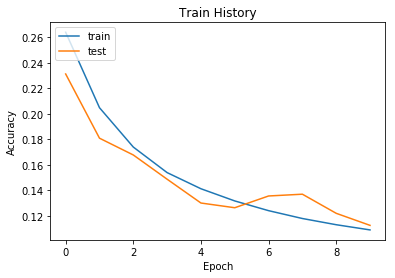

In [23]:
show_train_history('loss','val_loss')